## Predicting Final Element in Digit Sequences Using Machine Learning
***

For many years’ scientists have been trying to discover new patterns in number sequences and developing formulas and theorems that describe the fundamentals of such patterns. Those sequences are not mere mathematical curiosities but powerful tools for many fields like number theory, combinatorics, and discrete mathematics.

Currently there are many software applications that provide computational algebraic analysis and graphical capabilities that help scientist if their quests of finding and defining new sequences, at first glance it may seem like this symbiotic relation between man and machine will continue to be the main source of new sequences, unless a deeper level of analysis of how patterns arise can be achieved, so new sequences can be discovered based on a fundamental understanding of their nature instead of a one-to-one basis.

In consequence there is a clear need of better tools for understanding how sequences behave and predict such behavior, and this is the problem I decided to tackle: predict the next number in a specific sequence based on how it behaves. For this I implemented a Logistic Regression using a dataset of integer sequences where I can create classifiers and features based on the behavior of the sequences, i.e. whether it contains zeroes or negatives, or the divisibility of the last digit. All this with the objective of generating an accuracy score to evaluate how good the algorithm predicts a subsequent digit in a sequence.

For this solution we have used a subset of the OEIS dataset obtained from the Kaggle platform, it contains the majority of the integer sequences from the OEIS. It is split into a training set, where the full sequences are given, and a test set, where the last number from the sequence has been removed. The datasets were downloaded from the following link: https://www.kaggle.com/c/integer-sequence-learning/data. 

___

Let's start by importing all the required libraries:


In [245]:
import csv
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import metrics
import math
from decimal import Decimal
import warnings

warnings.filterwarnings('ignore')

Then we load the training set into a Pandas dataset, we count the number of sequences in both train and test datasets and print it:

In [219]:
# load training and test data into a Pandas Dataframe 
train = pd.read_csv('inputs/train.csv')
train_sequences = train.Sequence.str.split(',')
test = pd.read_csv('inputs/test.csv')
test_sequences = test.Sequence.str.split(',')

# this method count lines in in a file
def count_lines(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

# count number of sequences
number_of_lines_in_train_set = count_lines('inputs/train.csv')
number_of_lines_in_test_set = count_lines('inputs/test.csv')
print number_of_lines_in_train_set, number_of_lines_in_test_set

113846 113846


First we build a classifier to predict if the final element will be the most frequent final element of each sequence in the training set.

---

Let's find the most frequent final element and print it.

In [220]:
# this method gets the final element on the list, the tail
def tail(list):
    return list[-1]

# get all the final elements into an array
train_final_elements = train_sequences.apply(tail)
test_final_elements = test_sequences.apply(tail)
#get the most frequent final element and print it
most_frequent_final_element = train_final_elements.value_counts().index.tolist()[0]
print most_frequent_final_element

1


Get the indices of the lines of the dataset that are useful into an array

In [231]:
training_indices = np.int64(range(0,number_of_lines_in_train_set-1))
test_indices = np.int64(range(0,number_of_lines_in_test_set-1))

Now we create a classifier and the features using the training set.
***

First we write the methods we need to create the features.

In [222]:
# this method creates the final_element_count feature,
# that returns how frequent is final element in a sequence
"""        
:Pandas.series sequence: sequence of numbers
:return integer: how frequent is final element in sequence
"""
def how_frequent_is_final_element_in_sequence(sequence):
    result = 0
    for element in sequence[:-1]:
        if element == most_frequent_final_element:
            result += 1
    return result

# this method creates the max feature,
# that returns the maximum value in a sequence
"""        
:Pandas.series sequence: sequence of numbers
:return integer: maximum value in sequence
"""
def maximum_value_in_sequence(sequence):
    if sequence[:-1]:
        return max(list(map(int, sequence[:-1])))
    else:
        return None
    
# this method creates the negatives feature,
# that returns if there are negative values in a sequence
"""        
:Pandas.series sequence: sequence of numbers
:return boolean: is there a negative value in sequence
"""
def are_there_negative_values_in_sequence(sequence):
    matching = sum(1 for number in map(int, sequence[:-1]) if number < 0)
    if matching > 0:
        return True
    else:
        return False

# this method creates the zeroes feature,
# that returns if there are zero values in a sequence
"""        
:Pandas.series sequence: sequence of numbers
:return boolean: is there a zero value in sequence
"""
def are_there_any_zeroes_in_sequence(sequence):
    if 0 in map(int, sequence[:-1]):
        return True
    else:
        return False
    
# this method creates the even_odd_match feature,
# that returns if the final element divisibility by two matches that of the majority 
# of the numbers of the sequence
"""        
:Pandas.series sequence: sequence of numbers
:return boolean: does the final element divisibility by two matches that of the majority of the numbers of the sequence
"""
def even_odd_match_in_sequence(sequence):
    matching = sum(1 for number in map(int, sequence[:-1]) if number % 2 == int(most_frequent_final_element) % 2)
    unmatching = len(sequence[:-1]) - matching
    if matching > unmatching:
        return True
    else:
        return False

and the method we'll need to categorize features

In [223]:
# this methods creates a categorized version of a feature
"""        
:Pandas.dataframe features: dataframe with all the features
:String new_feature_name: the name of the new feature
:String feature_name: the name of the feature we need to categorize
:return void
"""
def create_categorized_version_of_feature(features,new_feature_name,feature_name):
    features[new_feature_name] = "First Level"
    features[new_feature_name][(features[feature_name] >= features[feature_name].quantile(.25)) & (features[feature_name]< features[feature_name].quantile(.5))] = "Second Level"
    features[new_feature_name][(features[feature_name] >= features[feature_name].quantile(.5)) & (features[feature_name]< features[feature_name].quantile(.75))] = "Third Level"
    features[new_feature_name][(features[feature_name] >= features[feature_name].quantile(.75))] = "Fourth Level"
    features[new_feature_name] = features[new_feature_name].astype("category", categories=["First Level","Second Level", "Third Level","Fourth Level"], ordered=True)


finally we can now create a Pandas dataframe with all the features

In [246]:
# Create features dataframe with all the features for the training dataset
features = pd.DataFrame({'final_element_count':train_sequences[training_indices].apply(how_frequent_is_final_element_in_sequence),
                       'negatives':train_sequences[training_indices].apply(are_there_negative_values_in_sequence),
                       'zeroes':train_sequences[training_indices].apply(are_there_any_zeroes_in_sequence),
                       'max':train_sequences[training_indices].apply(maximum_value_in_sequence),
                       'even_odd_match' : train_sequences[training_indices].apply(even_odd_match_in_sequence),
                       'features_class':train_final_elements[training_indices] == most_frequent_final_element,
                       })

# Categorized 'max' feature
create_categorized_version_of_feature(features,'max_categorized','max')

# Featrues Class feature (this is the dependent variable)
features['features_class'] = train_final_elements[training_indices] == most_frequent_final_element

## Plotting

For visualization purposes some of the features are categorized and then plotted using the plotPredictibility method.
***

First we create the method for plotting the features

In [232]:
# This method receive information about the information to be plotted and
# the format of such information, it transform numeric data to scientific notation
# if necessary, and formats the x axis labels, before plotting the feature
"""        
:Pandas.Series x_quantiles: y axis values
:Pandas.Series class_probabilities: x axis values
:Boolean labels: indicates if the x axis ticks will have labels
:Boolean numeric: indicates if the values for x are numeric
:Boolean boolean: indicates if the values for x are boolean
:return void
"""
def plot_predictibility(x_quantiles,class_probabilities,y_label,x_label,labels=False,numeric=False,boolean=False):
    plt.plot(range(0,len(x_quantiles)),class_probabilities, 'ro')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    x_labels = None
    if numeric == True:
        formatting_function = np.vectorize(lambda f: format(f, '6.3E'))
        x_labels = formatting_function(class_probabilities)
    else:
        x_labels = class_probabilities
    if labels == True:
        plt.xticks(range(0,len(x_quantiles)), x_labels, rotation='vertical')
    if boolean == True:
        plt.xticks(range(0,len(x_quantiles)), [True,False], rotation='vertical')
    plt.show()

now we plot the features

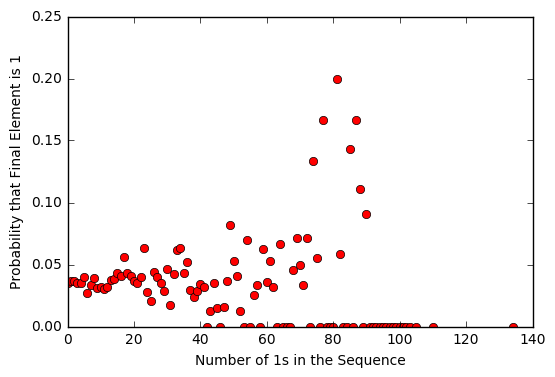

In [233]:
# How predictive is final_element_count feature?
def number_of_ocurrences_of_element_in_sequence(count):
    return (train_final_elements[training_indices][features['final_element_count']==count]==most_frequent_final_element).mean()

max_count_of_element = features['final_element_count'].max()
class_probabilities = pd.Series(range(0,max_count_of_element)).apply(number_of_ocurrences_of_element_in_sequence)
plot_predictibility(range(0,max_count_of_element),class_probabilities,"Probability that Final Element is " + most_frequent_final_element,"Number of " + most_frequent_final_element + "s in the Sequence")

113789 113789


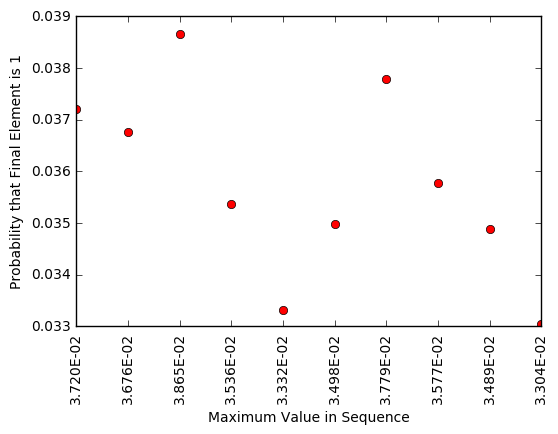

In [243]:
# How predictive is max feature?
# Categorizing is made for the sake of visualization
def final_elements_by_category(elements):
    return (elements == most_frequent_final_element).mean()

categories = pd.cut(map(float, features['max'].dropna()),features['max'].dropna().quantile(np.arange(0,1.1,0.1)))
class_probabilities = train_final_elements[training_indices][56:].groupby(categories).apply(final_elements_by_category)
plot_predictibility(categories.categories,class_probabilities,"Probability that Final Element is " + most_frequent_final_element,"Maximum Value in Sequence",True,True)

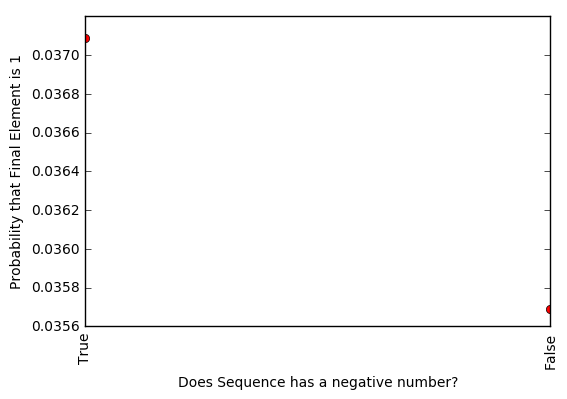

In [235]:
# How predictive is negatives feature?
class_probabilities = [(train_final_elements[training_indices][features['negatives']]==most_frequent_final_element).mean(),(train_final_elements[training_indices][~features['negatives']]==most_frequent_final_element).mean()]
plot_predictibility(range(0,len(class_probabilities)),class_probabilities,"Probability that Final Element is " + most_frequent_final_element,"Does Sequence has a negative number?",boolean=True)

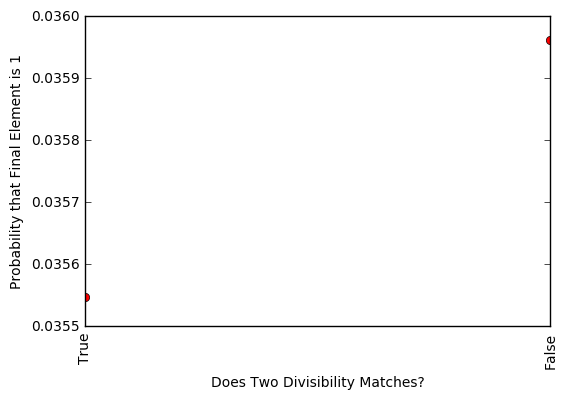

In [236]:
# How predictive is even_odd_match feature?
class_probabilities = [(train_final_elements[training_indices][features['even_odd_match']]==most_frequent_final_element).mean(),(train_final_elements[training_indices][~features['even_odd_match']]==most_frequent_final_element).mean()]
plot_predictibility(range(0,len(class_probabilities)),class_probabilities,"Probability that Final Element is " + most_frequent_final_element,"Does Two Divisibility Matches?",boolean=True)

## Fitting and Predicting

Now we use a Logistic regression to fit the data

In [225]:
# Fit the model using a logistic regression and print the result
fit = smf.glm(formula="features_class ~ final_element_count + max_categorized + negatives + zeroes + even_odd_match", family=sm.families.Binomial(), data=features).fit()
print fit.summary()

                                 Generalized Linear Model Regression Results                                 
Dep. Variable:     ['features_class[False]', 'features_class[True]']   No. Observations:               113845
Model:                                                           GLM   Df Residuals:                   113837
Model Family:                                               Binomial   Df Model:                            7
Link Function:                                                 logit   Scale:                             1.0
Method:                                                         IRLS   Log-Likelihood:                -11542.
Date:                                               Sun, 18 Dec 2016   Deviance:                       23084.
Time:                                                       23:57:32   Pearson chi2:                 6.77e+04
No. Iterations:                                                   12                                         
          

Now we creates the features for the test dataset

In [227]:
# Create features dataframe with all the features for the test dataset
features = pd.DataFrame({'final_element_count':test_sequences[test_indices].apply(how_frequent_is_final_element_in_sequence),
                       'negatives':test_sequences[test_indices].apply(are_there_negative_values_in_sequence),
                       'zeroes':test_sequences[test_indices].apply(are_there_any_zeroes_in_sequence),
                       'max':test_sequences[test_indices].apply(maximum_value_in_sequence),
                       'even_odd_match' : test_sequences[test_indices].apply(even_odd_match_in_sequence),
                       'features_class':test_final_elements[test_indices] == most_frequent_final_element,
                       })

# Categorized 'max' feature
create_categorized_version_of_feature(features,'max_categorized','max')

/Users/bpolania/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/bpolania/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/bpolania/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Finally we make a prediction and get and AUC Score

In [228]:
# make prediction based on the fit date
predictions = fit.predict(features)

# Get AUC ROC for the prediction
prediction = (1 - metrics.roc_auc_score(features['features_class'],predictions))

print prediction

0.950483345333
